In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from LP import LP
from DeepLP import DeepLP
from DeepLP_Sparse import DeepLP_Sparse
from DeepLP_RBF import DeepLP_RBF
from DeepLP_WeightedRBF import DeepLP_WeightedRBF
from DeepLP_WeightedRBF_t import DeepLP_WeightedRBF_t

from utils import *

# Data Preparation

In [2]:
# get labels, features and weights
LX, Ly, UX, Uy, Uy_sol = get_iris_data()
features = np.vstack((LX,UX))
true_labels = np.hstack((Ly,Uy_sol))
weights = rbf_kernel(features)
num_features = features.shape[1]
num_labeled = len(Ly)
num_unlabeled = len(Uy)
num_nodes = num_labeled+num_unlabeled
graph = (weights > 0).astype(int)

In [3]:
# prepare features for NN
LY = np.tile(Ly,(Ly.shape[0],1))
np.fill_diagonal(LY, 0.5)
UY = np.tile(Uy,(Ly.shape[0],1))

masked_ = np.hstack((np.identity(LY.shape[0]),np.zeros((Ly.shape[0],Uy.shape[0]))))
true_labeled = np.array([1] * LY.shape[0] + [0] * Uy.shape[0]).reshape(1,100)

In [4]:
unlabeled_test = np.hstack((np.zeros(LY.shape[0]),np.ones((Uy.shape[0])))).reshape(1,100)
test_data = {
    'X': np.hstack((Ly,Uy)).reshape(1,100),
    'y': np.tile(true_labels,(Ly.shape[0],1))[1:2],
    'unlabeled': unlabeled_test,
    'labeled': (1 - unlabeled_test).reshape(1,100),
    'true_labeled': true_labeled,
    'masked':masked_[0:1]
}

In [5]:
unlabeled_ = np.hstack((np.identity(LY.shape[0]),np.ones((Ly.shape[0],Uy.shape[0]))))
data = {
    'X':np.hstack((LY, UY)),
    'y':np.reshape(true_labels,(1,len(true_labels))),
    'unlabeled':unlabeled_,
    'labeled':1-unlabeled_,
    'true_labeled': true_labeled,
    'masked':masked_
}

# Label Propagation

In [6]:
lp = LP()
Uy_lp = np.rint(lp.closed(features,Ly))
Uy_lp_iter = np.rint(lp.iter_(features,Ly,Uy,1000))

In [7]:
print("[Accuracy] Closed solution:", accuracy(Uy_sol, Uy_lp), " Iter Solution:", accuracy(Uy_sol, Uy_lp_iter))
print("[RMSE] Closed solution", rmse(Uy_sol, Uy_lp), " Iter solution", rmse(Uy_sol, Uy_lp))

[Accuracy] Closed solution: 0.8  Iter Solution: 0.8
[RMSE] Closed solution 0.2  Iter solution 0.2


In [17]:
# for iter_ in [1,2,3,4,5,10,100,1000]:
#     print(iter_)
#     Uy_lp_iter = np.rint(lp.iter_(features,Ly,Uy,iter_))
#     print("Objective:", objective(Ly,np.rint(Uy_lp_iter),weights))
#     print("Accuracy:", accuracy(Uy_sol,Uy_lp_iter))
#     print("RMSE:", rmse(Uy_sol,Uy_lp_iter))

In [18]:

# dlps = DeepLP_Sparse(10, num_nodes, weights, 1)

# DeepLP

In [19]:
dlp = DeepLP(10, num_nodes, weights, 1)

In [20]:
pred_dlp = dlp.labelprop(test_data)
Uy_dlp = np.rint(pred_dlp[:,num_labeled:]).reshape(num_unlabeled)

In [21]:
print("Accuracy:", accuracy(Uy_sol,Uy_dlp))
print("RMSE:", rmse(Uy_sol,Uy_dlp))
print("Objective:", objective(Ly,Uy_dlp,dlp.get_val(dlp.W)))

Accuracy: 0.8
RMSE: 0.2


# DeepLP_RBF

In [6]:
dlp_rbf = DeepLP_RBF(10, num_nodes, features, graph, np.var(features), 0.01)

In [7]:
pred_dlp_rbf = dlp_rbf.labelprop(test_data)
Uy_dlp_rbf = np.rint(pred_dlp_rbf[:,num_labeled:]).reshape(num_unlabeled)

In [9]:
print("Accuracy:", accuracy(Uy_sol,Uy_dlp_rbf))
print("RMSE:", rmse(Uy_sol,Uy_dlp_rbf))
print("Objective:", objective(Ly,Uy_dlp_rbf,dlp_rbf.get_val(dlp_rbf.W)))

Accuracy: 0.8
RMSE: 0.2
Objective: 1271.07191023


In [10]:
dlp_rbf.train(data,test_data,100)

epoch: -1 labeled loss: 0.295816 unlabeled loss: 0.228928 accuracy: 0.64 sol unlabeled loss: 0.219636 sol accuracy: 0.8
epoch: 0 labeled loss: 0.295355 unlabeled loss: 0.228564 accuracy: 0.644 sol unlabeled loss: 0.219145 sol accuracy: 0.8
sigma: 3.46386
epoch: 10 labeled loss: 0.289176 unlabeled loss: 0.222999 accuracy: 0.696 sol unlabeled loss: 0.211571 sol accuracy: 0.863158
epoch: 20 labeled loss: 0.283025 unlabeled loss: 0.2149 accuracy: 0.746 sol unlabeled loss: 0.198821 sol accuracy: 0.873684
epoch: 30 labeled loss: 0.282953 unlabeled loss: 0.214426 accuracy: 0.754 sol unlabeled loss: 0.197766 sol accuracy: 0.873684
epoch: 40 labeled loss: 0.282953 unlabeled loss: 0.214401 accuracy: 0.754 sol unlabeled loss: 0.197706 sol accuracy: 0.873684
epoch: 50 labeled loss: 0.282953 unlabeled loss: 0.214404 accuracy: 0.754 sol unlabeled loss: 0.197715 sol accuracy: 0.873684
epoch: 60 labeled loss: 0.282953 unlabeled loss: 0.214405 accuracy: 0.754 sol unlabeled loss: 0.197715 sol accuracy: 

In [11]:
argmax = np.argmax(dlp_rbf.accuracies)

In [12]:
pred_dlp_rbf = np.rint(dlp_rbf.pred(test_data,dlp_rbf.sigmas[argmax]))
Uy_dlp_rbf = np.rint(pred_dlp_rbf[:,num_labeled:]).reshape(num_unlabeled)

In [14]:
print("Accuracy:", accuracy(Uy_sol,Uy_dlp_rbf))
print("RMSE:", rmse(Uy_sol,Uy_dlp_rbf))
print("Objective:", objective(Ly,Uy_dlp_rbf,dlp_rbf.get_val(dlp_rbf.W)))

Accuracy: 0.873684210526
RMSE: 0.126315789474
Objective: 1218.36465532


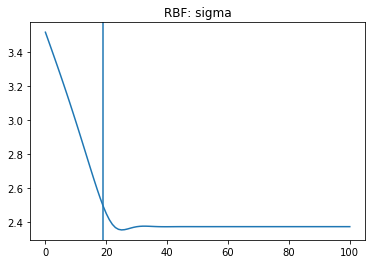

In [15]:
plt.plot(dlp_rbf.sigmas)
plt.title("RBF: sigma")
plt.axvline(x=19)
plt.show()

In [16]:
# plt.plot(range(20,100+1),dlp_rbf.sigmas[20:])
# plt.title("RBF: sigma (iter 20-100)")
# plt.show()

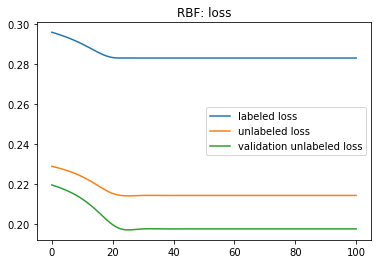

In [17]:
plt.plot(dlp_rbf.labeled_losses,label="labeled loss")
plt.plot(dlp_rbf.unlabeled_losses,label="unlabeled loss")
plt.plot(dlp_rbf.sol_unlabeled_losses,label='validation unlabeled loss')
plt.title("RBF: loss")
plt.legend()
# plt.axvline(x=19)
plt.show()

In [ ]:
# plt.plot(range(20,100+1),dlp_rbf.labeled_losses[20:],label="labeled loss")
# # plt.plot(dlp_rbf.unlabeled_losses,label="unlabeled loss")
# plt.title("RBF: labeled loss (iter 20-100)")
# plt.legend()
# plt.show()

In [10]:
# # plt.plot(range(20,100+1),dlp_rbf.labeled_losses[20:],label="labeled loss")
# plt.plot(range(20,100+1),dlp_rbf.unlabeled_losses[20:],label="unlabeled loss")
# plt.title("RBF: unlabeled loss (iter 20-100)")
# plt.legend()
# plt.show()

In [18]:
plt.plot(dlp_rbf.accuracies,label="DeepLP, train")
plt.plot([accuracy(Uy_sol,Uy_dlp)] * len(dlp_rbf.accuracies),label="LP")
plt.plot(dlp_rbf.sol_accuracies,label="DeepLP, validation")
plt.title("RBF: accuracy")
plt.legend()
plt.show()

NameError: name 'Uy_dlp' is not defined

# DeepLP_WeightedRBF

In [7]:
# theta = np.ones(num_features)
theta = np.array([ 1 ,  1,  1,  1 ])

In [8]:
dlp_wrbf = DeepLP_WeightedRBF(10, num_nodes, features, graph, np.var(features), theta, 0.01, 0)

In [9]:
pred_dlp_wrbf = dlp_wrbf.labelprop(test_data)
Uy_dlp_wrbf = np.rint(pred_dlp_wrbf[:,num_labeled:]).reshape(num_unlabeled)

In [10]:
print("Accuracy:", accuracy(Uy_sol,Uy_dlp_wrbf))
print("RMSE:", rmse(Uy_sol,Uy_dlp_wrbf))
print("Objective:", objective(Ly,Uy_dlp_wrbf,dlp_wrbf.get_val(dlp_wrbf.W)))

Accuracy: 0.8
RMSE: 0.2
Objective: 1271.07191023


In [11]:
dlp_wrbf.train(data,test_data,200)

epoch: -1 labeled loss: 0.295816 unlabeled loss: 0.228928 accuracy: 0.64 sol unlabeled loss: 0.219636 sol accuracy: 0.8
0.016482830047607422
0.02811598777770996
epoch: 0 labeled loss: 0.295139 unlabeled loss: 0.228773 accuracy: 0.644 sol unlabeled loss: 0.219444 sol accuracy: 0.8
theta: [ 0.99000031  0.99000043  1.00999987  1.00999975]


In [25]:
argmax = np.argmax(dlp_wrbf.accuracies)

In [26]:
argmax

17

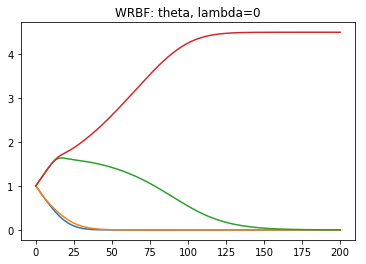

In [32]:
plt.plot(dlp_wrbf.thetas)
plt.title("WRBF: theta, lambda=0")
# plt.axvline(x=argmax)
# plt.axvline(x=33)
plt.show()

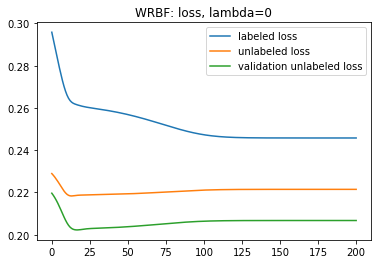

In [33]:
plt.plot(dlp_wrbf.labeled_losses,label='labeled loss')
plt.plot(dlp_wrbf.unlabeled_losses,label='unlabeled loss')
plt.plot(dlp_wrbf.sol_unlabeled_losses,label='validation unlabeled loss')
plt.title("WRBF: loss, lambda=0")
# plt.axvline(x=argmax)
# plt.axvline(x=33)
plt.legend()
plt.show()

In [34]:
plt.plot(dlp_wrbf.accuracies,label='WRBF')
plt.plot(dlp_wrbf.sol_accuracies,label='WRBF validation')
plt.plot([accuracy(Uy_sol,Uy_dlp)] * len(dlp_wrbf.accuracies),label="LP")
plt.title("WRBF: accuracy, lambda=0")
plt.legend()
# plt.axvline(x=argmax)
# plt.axvline(x=33)
plt.show()

NameError: name 'Uy_dlp' is not defined

In [35]:
# accuracies = []
# rmses = []
# objectives = []
# for sigma_ in sorted(sigmas):
#     dlp_rbf = DeepLP_RBF(10, num_nodes, features, graph, sigma_, 0.1)
#     pred_dlp_rbf = dlp_rbf.labelprop(test_data)
#     Uy_dlp_rbf = np.rint(pred_dlp_rbf[:,num_labeled:]).reshape(num_unlabeled)
#     print("Accuracy:", accuracy(Uy_sol,Uy_dlp_rbf))
#     print("RMSE:", rmse(Uy_sol,Uy_dlp_rbf))
#     print("Objective:", objective(Ly,Uy_dlp_rbf,dlp_rbf.get_value(dlp_rbf.W)))
    
#     accuracies.append(accuracy)
#     rmses.append(rmse)
#     objectives.append(objective)


In [36]:
from sklearn.utils.extmath import cartesian
l = np.arange(0,4.5,0.1)
l4 = [l for i in range(4)]
thetas = cartesian(l4)

In [37]:
accuracies = []
rmses = []
objectives = []
dlp_wrbf = DeepLP_WeightedRBF_t(10, num_nodes, features, graph, np.var(features), 'a', 0.01)

TypeError: __init__() missing 1 required positional argument: 'session'

In [38]:

for i,theta_ in enumerate(thetas): 
#     print(theta_)
    if i % 1 == 0:
        print(i)
    test_data['theta'] = theta_.reshape(1,4)
    
    pred_dlp_wrbf = dlp_wrbf.labelprop(test_data)
    Uy_dlp_wrbf = np.rint(pred_dlp_wrbf[:,num_labeled:]).reshape(num_unlabeled)
    accuracies.append(accuracy(Uy_sol,Uy_dlp_wrbf))
    rmses.append(rmse(Uy_sol,Uy_dlp_wrbf))
#     print("Accuracy:", accuracies[-1])
#     print("RMSE:", rmses[-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


KeyboardInterrupt: 

In [ ]:
np.argmax(accuracies)

In [ ]:
thetas[6334]

In [ ]:
np.savetxt('thetas.csv',thetas,delimiter=',')

In [ ]:
np.savetxt('accuracies.csv',accuracies,delimiter=',')

In [ ]:
np.savetxt('rmses.csv',rmses,delimiter=',')

In [ ]:
accuracies = np.loadtxt('accuracies.csv',delimiter=',')

In [ ]:
thetas = np.loadtxt('thetas.csv',delimiter=',')

In [ ]:
opt = [rmse for theta,acc,rmse in zip(thetas,accuracies,rmses) if theta[0]==0.9 and theta[1]==0.9 and theta[2]==1.35 and theta[3]==0.9]

In [ ]:
for a,b in zip(thetas,accuracies):
    print(a)
    break

In [ ]:
opt

In [ ]:
np.where(thetas==[ 0.9 ,  0.9 ,  1.35,  0.9 ])

In [ ]:
thetas.shape

In [ ]:
sum(thetas==[ 0.9 ,  0.9 ,  1.35,  0.9 ])

In [ ]:
np.argmax(accuracies)

In [ ]:
thetas[6334]

In [ ]:
rmses = np.loadtxt('rmses.csv',delimiter=',')

In [ ]:
len(rmses)

In [ ]:
np.argmin(rmses)

In [ ]:
rmses[6334]

In [ ]:
from sklearn.utils.extmath import cartesian
l = np.arange(0,4.5,1.5)
l4 = [l for i in range(4)]
thetas = cartesian(l4)

In [ ]:
len(thetas)

In [ ]:
theta = np.random.uniform(0,4.5,4)

In [ ]:
w.writerow('t')

In [ ]:
w.writerow(['hi'])

In [ ]:
outfile = open('no_reg.csv', 'a')
writer=csv.writer(outfile)
# writer.writerow(np.concatenate((theta,[dlp_wrbf.accuracies[-1],dlp_wrbf.labeled_losses[-1],dlp_wrbf.unlabeled_losses[-1],dlp_wrbf.sol_accuracies[-1],dlp_wrbf.sol_unlabeled_losses[-1]])))
writer.writerow(['theta1','theta2','theta3','theta4']+['accuracy','labeled_loss','unlabeled_loss','sol_accuracy','sol_unlabeled_loss'])
outfile.close()

In [ ]:
theta

In [ ]:
writer.writerow(np.concatenate((theta,[dlp_wrbf.accuracies[-1],dlp_wrbf.labeled_losses[-1],dlp_wrbf.unlabeled_losses[-1],dlp_wrbf.sol_accuracies[-1],dlp_wrbf.sol_unlabeled_losses[-1]])))

In [ ]:
[dlp_wrbf.accuracies[-1],dlp_wrbf.labeled_losses[-1],dlp_wrbf.unlabeled_losses[-1],dlp_wrbf.sol_accuracies[-1],dlp_wrbf.sol_unlabeled_losses[-1]]

In [ ]:
import time
start = time.time()
import csv 
import sys

w = csv.writer(open('no_reg.csv', 'a'), delimiter=',')
w1 = csv.writer(open('reg.csv', 'a'), delimiter=',')

i=0


theta = np.random.uniform(0,4.5,4)
dlp_wrbf = DeepLP_WeightedRBF(10, num_nodes, features, graph, np.var(features), theta, 0.01, 0)


In [ ]:

while True:
    start = time.time()
    theta = np.random.uniform(0,4.5,4)
    print("----------------------------------")
    print("theta:",str(i),theta)
    print("----------------------------------")    
    
    dlp_wrbf.train(data,test_data,200)
    
#     w.writerow([dlp_wrbf.accuracies[-1],dlp_wrbf.labeled_losses[-1],dlp_wrbf.unlabeled_losses[-1],dlp_wrbf.sol_accuracies[-1],dlp_wrbf.sol_unlabeled_losses[-1]])
    
    print(time.time() - start)
    
    print("----------------------------------")
    start = time.time()
    dlp_wrbf.train(data,test_data,200)
    
#     w1.writerow([dlp_wrbf.accuracies[-1],dlp_wrbf.labeled_losses[-1],dlp_wrbf.unlabeled_losses[-1],dlp_wrbf.sol_accuracies[-1],dlp_wrbf.sol_unlabeled_losses[-1]])
    
    print(time.time() - start)
    
    i+=1


----------------------------------
theta: 0 [ 4.44092307  1.70387173  4.16215141  4.07150065]
----------------------------------
epoch: -1 labeled loss: 0.323988 unlabeled loss: 0.218093 accuracy: 0.638 sol unlabeled loss: 0.200907 sol accuracy: 0.715789
epoch: 0 labeled loss: 0.321796 unlabeled loss: 0.21741 accuracy: 0.64 sol unlabeled loss: 0.20023 sol accuracy: 0.736842
theta: [ 2.92053175  0.07978736  0.95197511  0.55978644]
epoch: 10 labeled loss: 0.296229 unlabeled loss: 0.209982 accuracy: 0.724 sol unlabeled loss: 0.190869 sol accuracy: 0.936842
theta: [ 2.3686955   0.00703635  1.44837785  1.07693708]
epoch: 20 labeled loss: 0.281114 unlabeled loss: 0.212791 accuracy: 0.792 sol unlabeled loss: 0.193374 sol accuracy: 0.894737
theta: [  1.76193094e+00   3.56979377e-04   1.61440194e+00   1.43879223e+00]
epoch: 30 labeled loss: 0.270711 unlabeled loss: 0.215892 accuracy: 0.756 sol unlabeled loss: 0.198297 sol accuracy: 0.884211
theta: [  1.23850989e+00  -3.52028474e-05   1.58478749

In [ ]:
np.savetxt('sol_unlabeled_losses_fin1_1.csv',sol_unlabeled_losses1,delimiter=',')

In [ ]:
accuracies=[]
labeled_losses=[]
unlabeled_losses=[]
sol_accuracies=[]
sol_unlabeled_losses=[]
accuracies1=[]
labeled_losses1=[]
unlabeled_losses1=[]
sol_accuracies1=[]
sol_unlabeled_losses1=[]